In [1]:
import pandas as pd
import numpy as np
from arch import arch_model
from arch.univariate import GARCH, Normal
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

In [11]:
def perform_dcc_garch(df, date_column='date', p=1, q=1, plot_results=True):
    """
    Perform DCC-GARCH analysis on multivariate time series data.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing time series data with a date column
    date_column : str
        Name of the date column (default: 'date')
    p : int
        GARCH lag order (default: 1)
    q : int
        ARCH lag order (default: 1)
    plot_results : bool
        Whether to plot correlation matrices (default: True)
    
    Returns:
    --------
    dict containing:
        - 'data': original data
        - 'returns': calculated returns
        - 'univariate_models': fitted GARCH models for each series
        - 'standardized_residuals': standardized residuals
        - 'dcc_params': DCC parameters (alpha, beta)
        - 'dynamic_correlations': time-varying correlation matrices
        - 'conditional_covariances': time-varying covariance matrices
    """
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Set date as index
    df[date_column] = pd.to_datetime(df[date_column])
    df.set_index(date_column, inplace=True)
    df = df.sort_index()
    
    # Calculate returns (log returns)
    returns = np.log(df / df.shift(1)).dropna()
    n_assets = returns.shape[1]
    n_obs = returns.shape[0]
    
    print(f"Data shape: {returns.shape}")
    print(f"Number of assets: {n_assets}")
    print(f"Number of observations: {n_obs}")
    
    # Step 1: Fit univariate GARCH(p,q) models
    print("\n" + "="*50)
    print("Step 1: Fitting univariate GARCH models...")
    print("="*50)
    
    univariate_models = {}
    standardized_residuals = pd.DataFrame(index=returns.index)
    conditional_volatilities = pd.DataFrame(index=returns.index)
    
    for col in returns.columns:
        print(f"\nFitting GARCH({p},{q}) for {col}...")
        
        # Fit GARCH model
        model = arch_model(returns[col], vol='Garch', p=p, q=q, rescale=False)
        fitted = model.fit(disp='off')
        
        univariate_models[col] = fitted
        
        # Extract standardized residuals
        standardized_residuals[col] = fitted.resid / fitted.conditional_volatility
        conditional_volatilities[col] = fitted.conditional_volatility
        
        print(f"  AIC: {fitted.aic:.2f}, BIC: {fitted.bic:.2f}")
    
    # Step 2: Estimate DCC parameters
    print("\n" + "="*50)
    print("Step 2: Estimating DCC parameters...")
    print("="*50)
    
    # Calculate unconditional correlation matrix
    R_bar = standardized_residuals.corr().values
    
    def dcc_likelihood(params, resid, R_bar):
        """Negative log-likelihood for DCC model"""
        alpha, beta = params
        
        if alpha < 0 or beta < 0 or alpha + beta >= 1:
            return 1e10
        
        n_obs, n_assets = resid.shape
        Q = R_bar.copy()
        log_likelihood = 0
        
        for t in range(n_obs):
            # Update Q (dynamic correlation)
            if t > 0:
                resid_outer = np.outer(resid[t-1], resid[t-1])
                Q = (1 - alpha - beta) * R_bar + alpha * resid_outer + beta * Q
            
            # Compute correlation matrix R
            Q_diag_sqrt = np.sqrt(np.diag(Q))
            Q_diag_inv = np.diag(1 / Q_diag_sqrt)
            R = Q_diag_inv @ Q @ Q_diag_inv
            
            # Ensure positive definite
            eigvals = np.linalg.eigvalsh(R)
            if np.min(eigvals) <= 0:
                return 1e10
            
            # Log-likelihood contribution
            log_likelihood += -0.5 * (np.log(np.linalg.det(R)) + 
                                      resid[t] @ np.linalg.inv(R) @ resid[t])
        
        return -log_likelihood
    
    # Optimize DCC parameters
    initial_params = [0.05, 0.90]
    result = minimize(dcc_likelihood, initial_params, 
                     args=(standardized_residuals.values, R_bar),
                     method='L-BFGS-B',
                     bounds=[(0.001, 0.3), (0.7, 0.999)])
    
    alpha, beta = result.x
    print(f"\nEstimated DCC parameters:")
    print(f"  Alpha (α): {alpha:.4f}")
    print(f"  Beta (β): {beta:.4f}")
    print(f"  α + β: {alpha + beta:.4f}")
    
    # Step 3: Compute dynamic conditional correlations and covariances
    print("\n" + "="*50)
    print("Step 3: Computing dynamic correlations and covariances...")
    print("="*50)
    
    Q_t = R_bar.copy()
    dynamic_correlations = np.zeros((n_obs, n_assets, n_assets))
    conditional_covariances = np.zeros((n_obs, n_assets, n_assets))
    
    for t in range(n_obs):
        if t > 0:
            resid_t = standardized_residuals.values[t-1]
            resid_outer = np.outer(resid_t, resid_t)
            Q_t = (1 - alpha - beta) * R_bar + alpha * resid_outer + beta * Q_t
        
        # Compute correlation matrix
        Q_diag_sqrt = np.sqrt(np.diag(Q_t))
        Q_diag_inv = np.diag(1 / Q_diag_sqrt)
        R_t = Q_diag_inv @ Q_t @ Q_diag_inv
        
        dynamic_correlations[t] = R_t
        
        # Compute covariance matrix
        D_t = np.diag(conditional_volatilities.values[t])
        H_t = D_t @ R_t @ D_t
        conditional_covariances[t] = H_t
    
    print("Computation complete!")
    
    # Plot results
    if plot_results and n_assets <= 10:
        plot_dcc_results(returns, dynamic_correlations, standardized_residuals)
    
    return {
        'data': df,
        'returns': returns,
        'univariate_models': univariate_models,
        'standardized_residuals': standardized_residuals,
        'conditional_volatilities': conditional_volatilities,
        'dcc_params': {'alpha': alpha, 'beta': beta},
        'dynamic_correlations': dynamic_correlations,
        'conditional_covariances': conditional_covariances,
        'unconditional_correlation': R_bar
    }

In [12]:
def plot_dcc_results(returns, dynamic_correlations, standardized_residuals):
    """Plot DCC-GARCH results"""
    
    n_assets = returns.shape[1]
    asset_names = returns.columns.tolist()
    
    # Plot 1: Dynamic correlations for all pairs
    n_pairs = n_assets * (n_assets - 1) // 2
    fig, axes = plt.subplots(n_pairs, 1, figsize=(12, 3*n_pairs))
    if n_pairs == 1:
        axes = [axes]
    
    pair_idx = 0
    for i in range(n_assets):
        for j in range(i+1, n_assets):
            corr_series = dynamic_correlations[:, i, j]
            axes[pair_idx].plot(returns.index, corr_series, linewidth=1)
            axes[pair_idx].set_title(f'Dynamic Correlation: {asset_names[i]} - {asset_names[j]}')
            axes[pair_idx].set_ylabel('Correlation')
            axes[pair_idx].grid(True, alpha=0.3)
            axes[pair_idx].axhline(y=0, color='r', linestyle='--', alpha=0.5)
            pair_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Heatmap of average correlations
    avg_corr = np.mean(dynamic_correlations, axis=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                xticklabels=asset_names, yticklabels=asset_names,
                vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
    plt.title('Average Dynamic Correlation Matrix')
    plt.tight_layout()
    plt.show()

## Lithium

Data shape: (312, 7)
Number of assets: 7
Number of observations: 312

Step 1: Fitting univariate GARCH models...

Fitting GARCH(1,1) for LIDALY...
  AIC: -1960.34, BIC: -1945.37

Fitting GARCH(1,1) for LISAME...
  AIC: -2429.97, BIC: -2415.00

Fitting GARCH(1,1) for LICOMX...
  AIC: -1366.32, BIC: -1351.34

Fitting GARCH(1,1) for LILAMC...
  AIC: -964.10, BIC: -949.13

Fitting GARCH(1,1) for LIEALC...
  AIC: -1636.62, BIC: -1621.65

Fitting GARCH(1,1) for LIEABG...
  AIC: -1603.37, BIC: -1588.40

Fitting GARCH(1,1) for LILMEX...
  AIC: -1734.58, BIC: -1719.60

Step 2: Estimating DCC parameters...

Estimated DCC parameters:
  Alpha (α): 0.0186
  Beta (β): 0.8266
  α + β: 0.8452

Step 3: Computing dynamic correlations and covariances...
Computation complete!


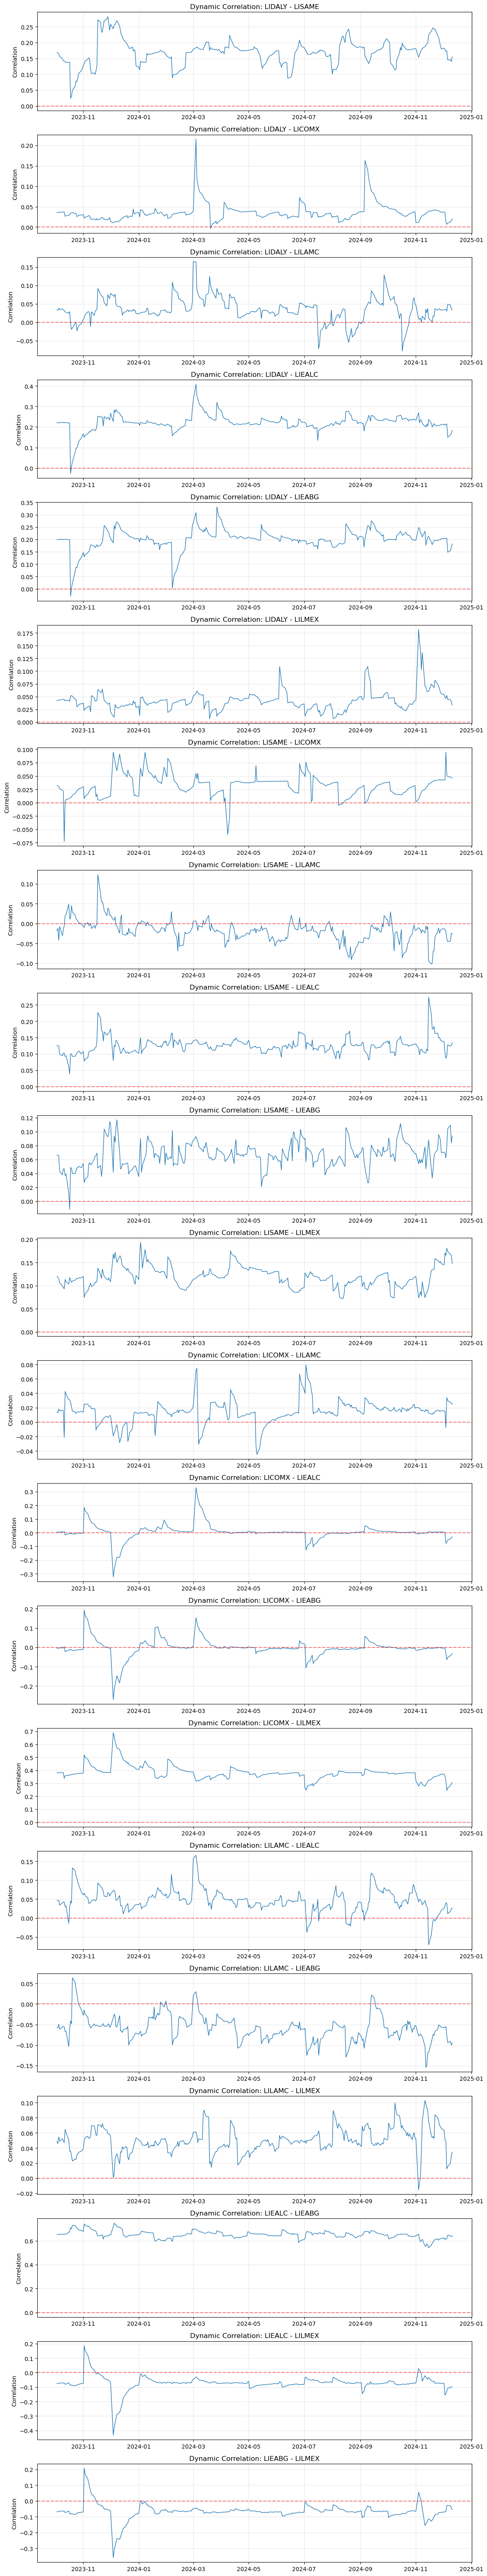

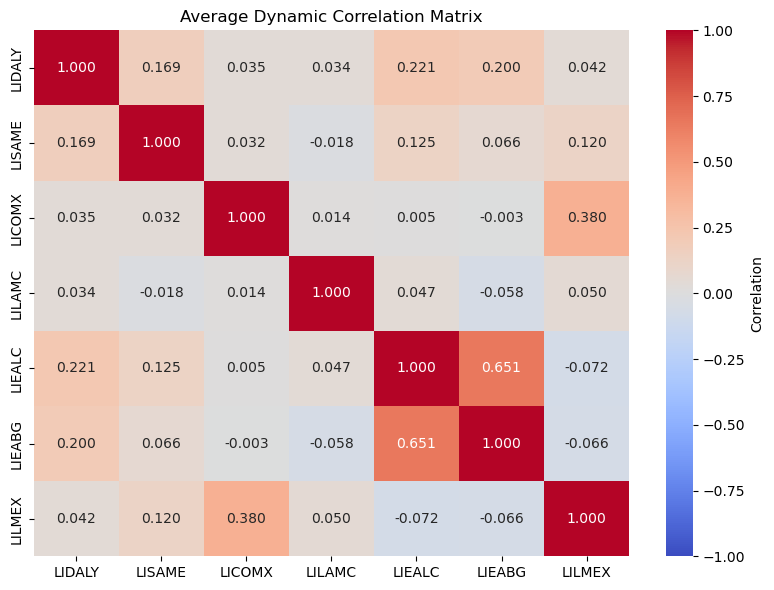

DCC parameters: {'alpha': np.float64(0.018603959028296264), 'beta': np.float64(0.8266192119696376)}

Unconditional Correlation Matrix:
[[ 1.          0.16860388  0.03553828  0.03383119  0.22045723  0.19906227
   0.04184702]
 [ 0.16860388  1.          0.03240282 -0.01859619  0.12534425  0.06641702
   0.12038544]
 [ 0.03553828  0.03240282  1.          0.01422     0.00440233 -0.00436781
   0.38079846]
 [ 0.03383119 -0.01859619  0.01422     1.          0.04663999 -0.05785212
   0.0486466 ]
 [ 0.22045723  0.12534425  0.00440233  0.04663999  1.          0.65172134
  -0.07503384]
 [ 0.19906227  0.06641702 -0.00436781 -0.05785212  0.65172134  1.
  -0.06786812]
 [ 0.04184702  0.12038544  0.38079846  0.0486466  -0.07503384 -0.06786812
   1.        ]]

Correlation at observation 100: 0.1189


In [14]:
df_lithium = pd.read_csv('data/ALL_lithium_prices_cubic_spline.csv')
lithium_results = perform_dcc_garch(df_lithium, date_column='Date', p=1, q=1, plot_results=True)

print("DCC parameters:", lithium_results['dcc_params'])
print("\nUnconditional Correlation Matrix:")
print(lithium_results['unconditional_correlation'])

# Get correlation between asset 0 and 1 at time t
t = 100
correlation_at_t = lithium_results['dynamic_correlations'][t, 0, 1]
print(f"\nCorrelation at observation {t}: {correlation_at_t:.4f}")

## Nickel

Data shape: (538, 6)
Number of assets: 6
Number of observations: 538

Step 1: Fitting univariate GARCH models...

Fitting GARCH(1,1) for NIDALY...
  AIC: -2895.52, BIC: -2878.37

Fitting GARCH(1,1) for NILMEX...
  AIC: -3020.54, BIC: -3003.39

Fitting GARCH(1,1) for NIETFN...
  AIC: -2965.48, BIC: -2948.33

Fitting GARCH(1,1) for NISHFE...
  AIC: -3278.20, BIC: -3261.04

Fitting GARCH(1,1) for NIWUXI...
  AIC: -3102.13, BIC: -3084.98

Fitting GARCH(1,1) for NIINDA...
  AIC: -3424.11, BIC: -3406.95

Step 2: Estimating DCC parameters...

Estimated DCC parameters:
  Alpha (α): 0.0626
  Beta (β): 0.7000
  α + β: 0.7626

Step 3: Computing dynamic correlations and covariances...
Computation complete!


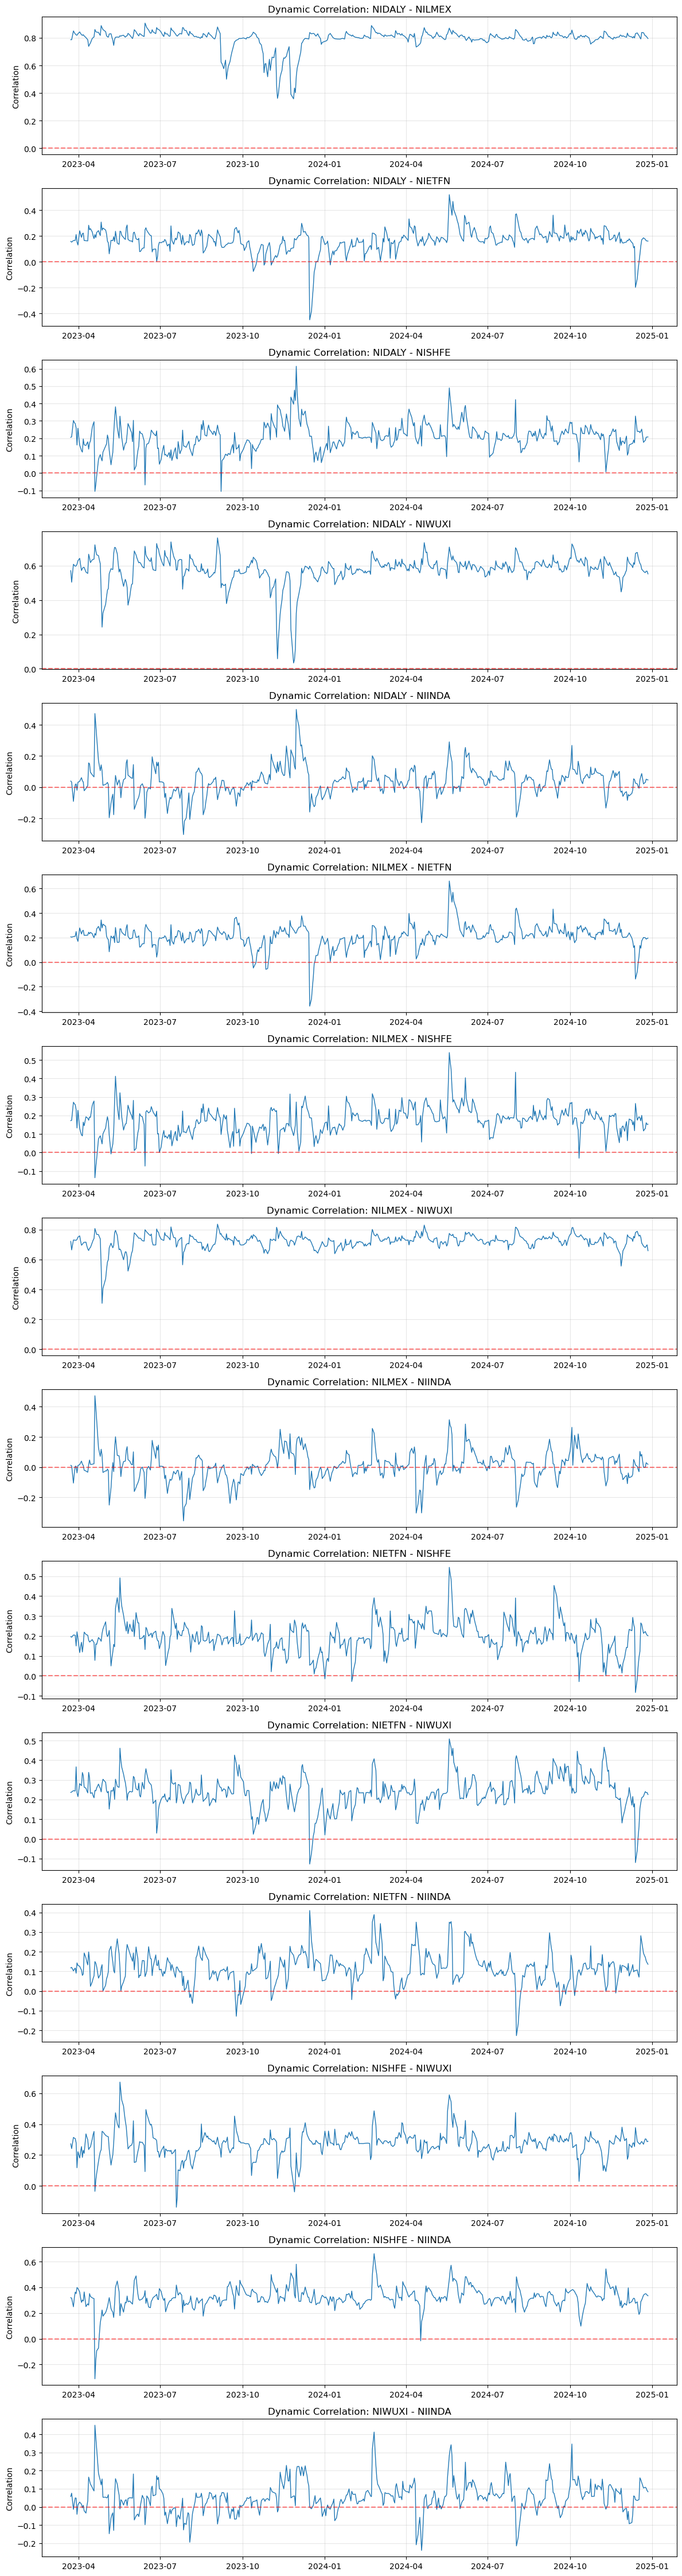

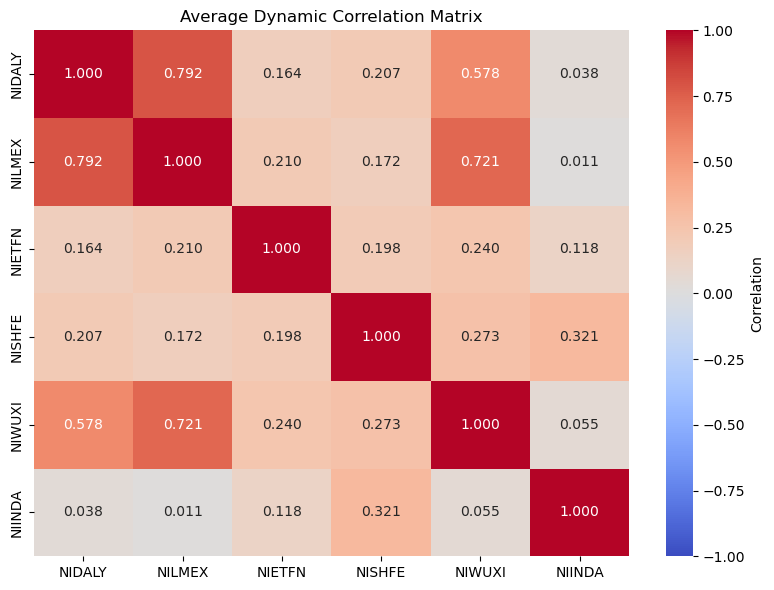

DCC parameters: {'alpha': np.float64(0.0626268292091709), 'beta': np.float64(0.7)}

Unconditional Correlation Matrix:
[[1.         0.78646637 0.15754954 0.20534277 0.57116005 0.03907368]
 [0.78646637 1.         0.2063666  0.17215679 0.72115181 0.01201621]
 [0.15754954 0.2063666  1.         0.19675965 0.23637722 0.11794671]
 [0.20534277 0.17215679 0.19675965 1.         0.27247364 0.3194301 ]
 [0.57116005 0.72115181 0.23637722 0.27247364 1.         0.0569798 ]
 [0.03907368 0.01201621 0.11794671 0.3194301  0.0569798  1.        ]]


In [15]:
df_nickel = pd.read_csv('data/ALL_nickel_prices_cubic_spline.csv')
nickel_results = perform_dcc_garch(df_nickel, date_column='Date', p=1, q=1, plot_results=True)
print("DCC parameters:", nickel_results['dcc_params'])
print("\nUnconditional Correlation Matrix:")
print(nickel_results['unconditional_correlation'])

## Cobalt

Data shape: (1293, 6)
Number of assets: 6
Number of observations: 1293

Step 1: Fitting univariate GARCH models...

Fitting GARCH(1,1) for CODALY...
  AIC: -7876.17, BIC: -7855.51

Fitting GARCH(1,1) for COLMEX...
  AIC: -8084.14, BIC: -8063.48

Fitting GARCH(1,1) for COLME3...
  AIC: -8121.52, BIC: -8100.86

Fitting GARCH(1,1) for COLMEA...
  AIC: -8239.47, BIC: -8218.81

Fitting GARCH(1,1) for COWUXI...
  AIC: -7203.80, BIC: -7183.14

Fitting GARCH(1,1) for COCOMX...
  AIC: -7316.73, BIC: -7296.07

Step 2: Estimating DCC parameters...

Estimated DCC parameters:
  Alpha (α): 0.0123
  Beta (β): 0.9861
  α + β: 0.9984

Step 3: Computing dynamic correlations and covariances...
Computation complete!


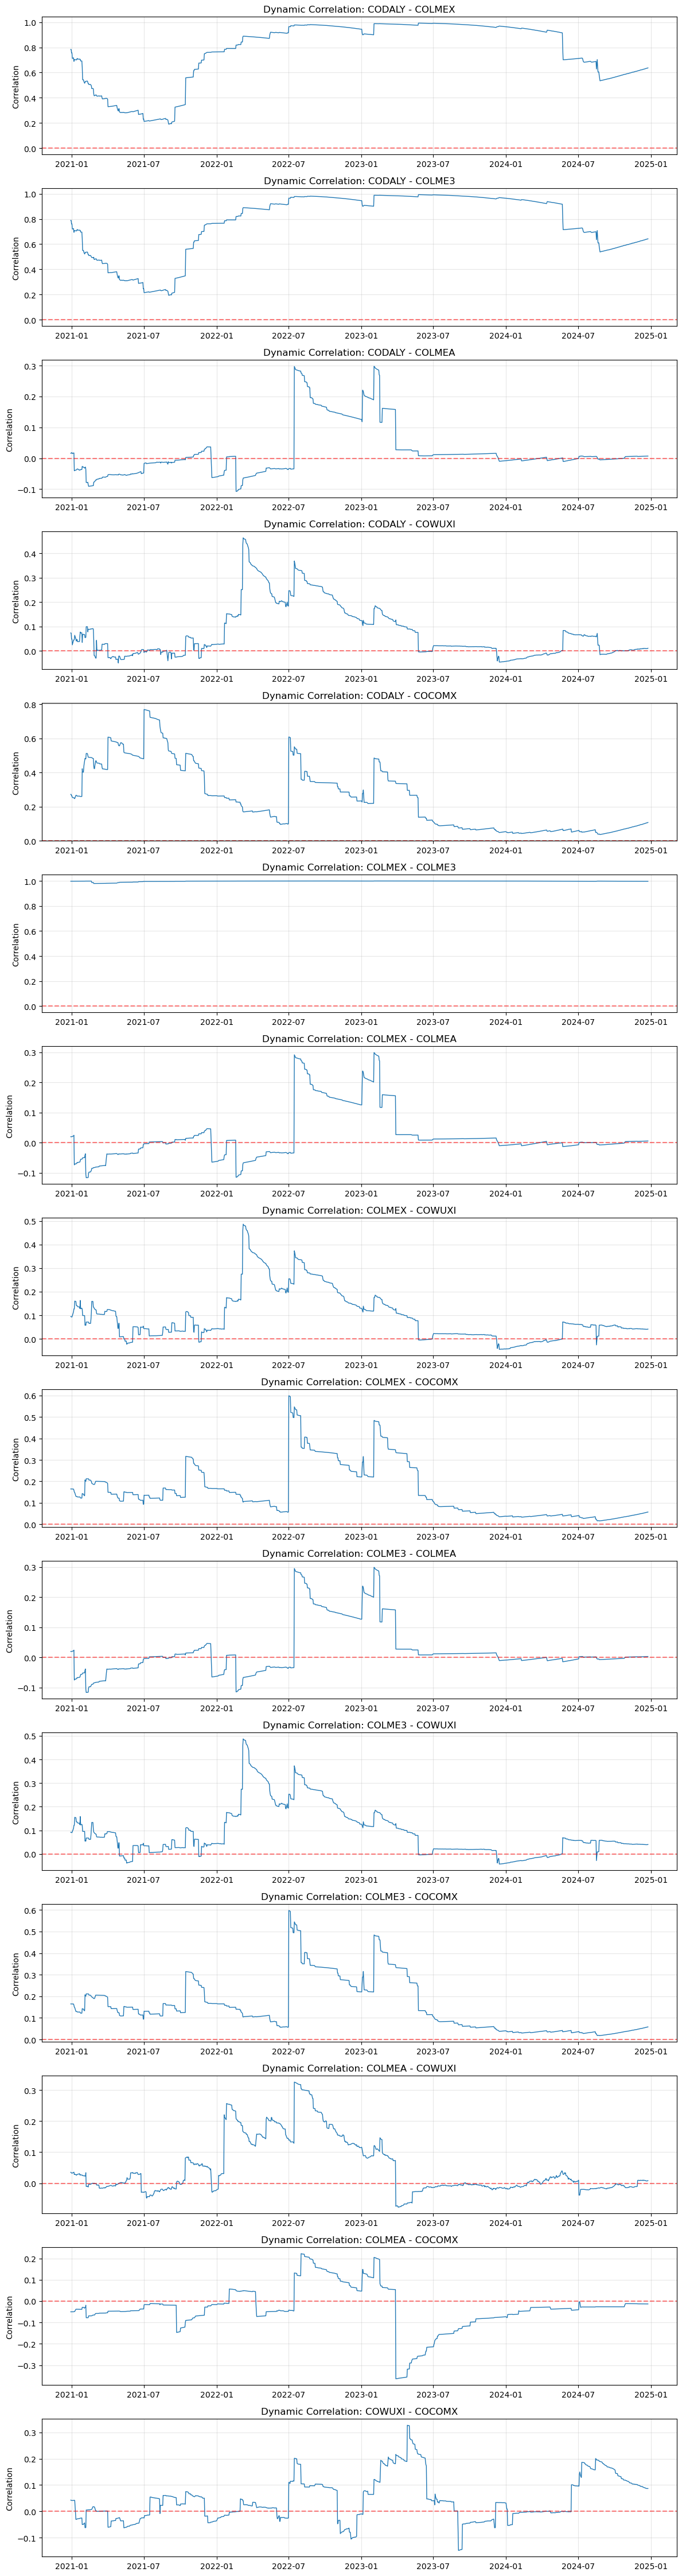

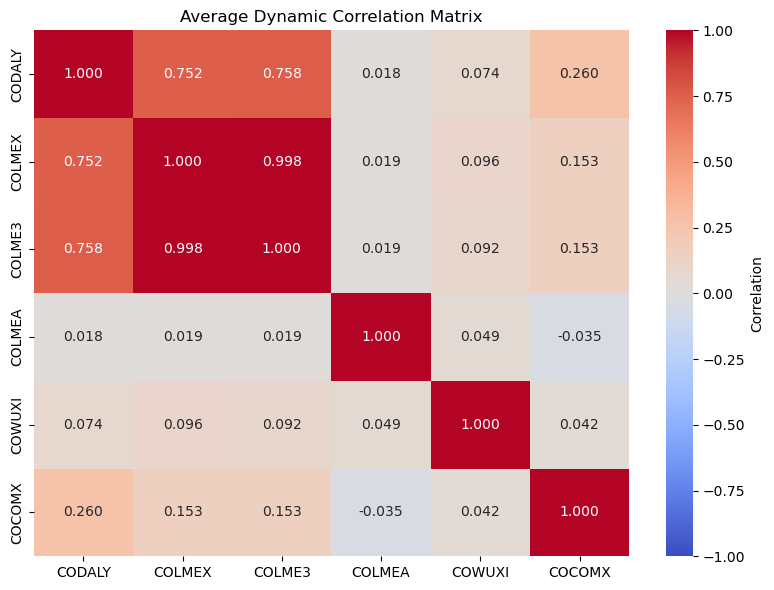

DCC parameters: {'alpha': np.float64(0.012283423374767273), 'beta': np.float64(0.9861086651059637)}

Unconditional Correlation Matrix:
[[ 1.          0.7834253   0.78832676  0.01630173  0.07367618  0.27204217]
 [ 0.7834253   1.          0.99818078  0.01968644  0.09470482  0.16457234]
 [ 0.78832676  0.99818078  1.          0.01975169  0.092234    0.1645966 ]
 [ 0.01630173  0.01968644  0.01975169  1.          0.03535313 -0.05010724]
 [ 0.07367618  0.09470482  0.092234    0.03535313  1.          0.04262563]
 [ 0.27204217  0.16457234  0.1645966  -0.05010724  0.04262563  1.        ]]


In [16]:
df_cobalt = pd.read_csv('data/ALL_cobalt_prices_cubic_spline.csv')
cobalt_results = perform_dcc_garch(df_cobalt, date_column='Date', p=1, q=1, plot_results=True)
print("DCC parameters:", cobalt_results['dcc_params'])
print("\nUnconditional Correlation Matrix:")
print(cobalt_results['unconditional_correlation'])

## Copper

Data shape: (214, 6)
Number of assets: 6
Number of observations: 214

Step 1: Fitting univariate GARCH models...

Fitting GARCH(1,1) for CUDALY...
  AIC: -1198.53, BIC: -1185.06

Fitting GARCH(1,1) for CUCOMX...
  AIC: -1195.78, BIC: -1182.32

Fitting GARCH(1,1) for CULMEX...
  AIC: -1271.24, BIC: -1257.77

Fitting GARCH(1,1) for CUSMMG...
  AIC: -1372.84, BIC: -1359.38

Fitting GARCH(1,1) for CUSHFE...
  AIC: -1430.79, BIC: -1417.33

Fitting GARCH(1,1) for CUETFC...
  AIC: -1049.14, BIC: -1035.67

Step 2: Estimating DCC parameters...

Estimated DCC parameters:
  Alpha (α): 0.0393
  Beta (β): 0.8268
  α + β: 0.8661

Step 3: Computing dynamic correlations and covariances...
Computation complete!


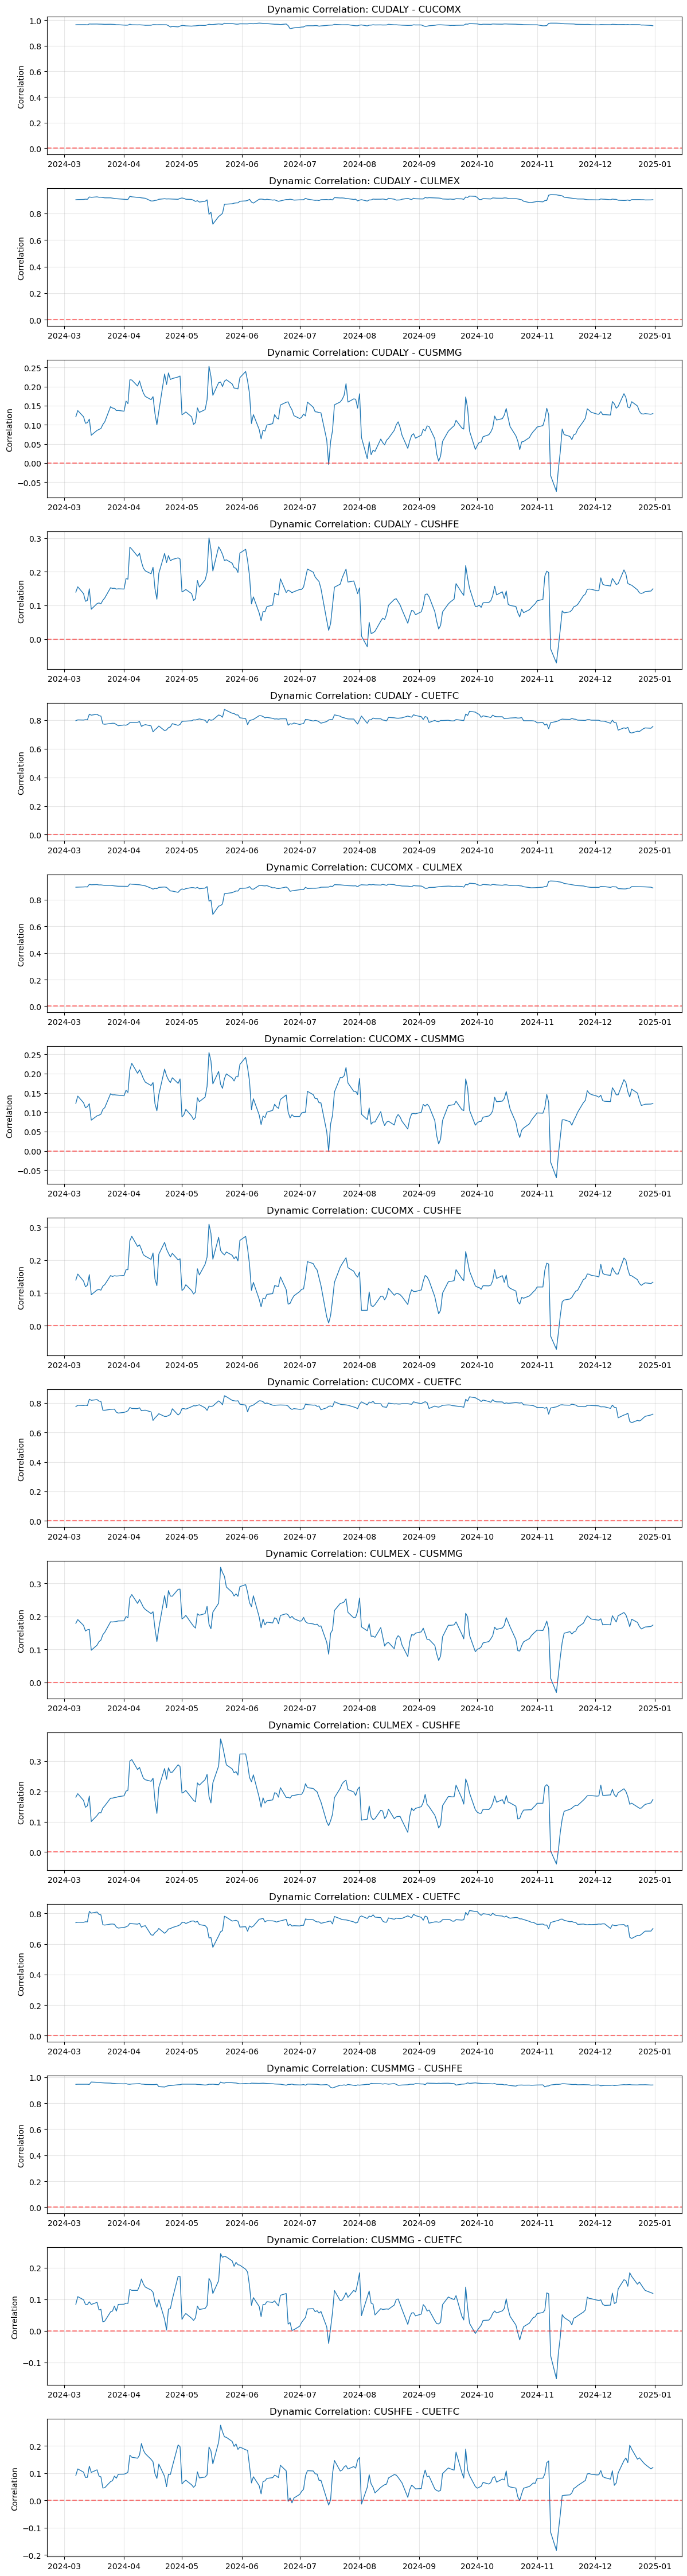

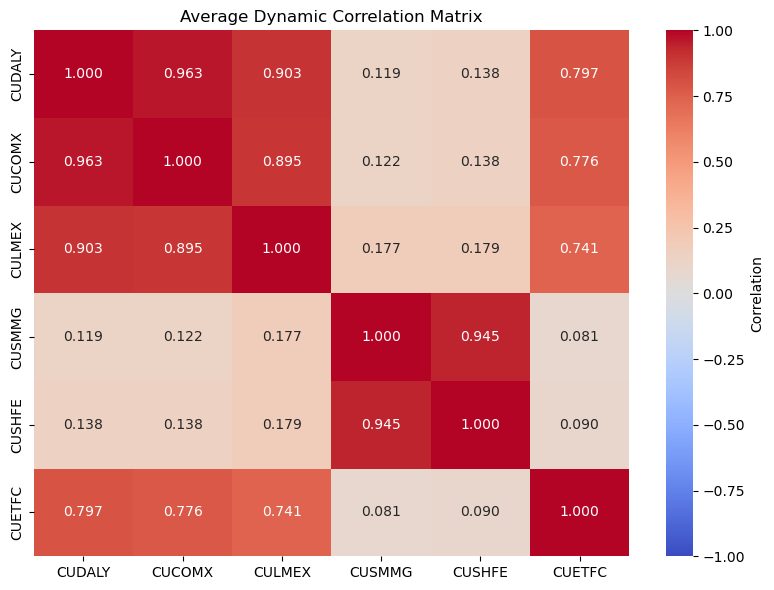

DCC parameters: {'alpha': np.float64(0.03930540725192171), 'beta': np.float64(0.8268384515473828)}

Unconditional Correlation Matrix:
[[1.         0.96349956 0.902758   0.12073385 0.13922446 0.7959914 ]
 [0.96349956 1.         0.8943521  0.12283819 0.13869637 0.7750218 ]
 [0.902758   0.8943521  1.         0.17874905 0.18079616 0.73994168]
 [0.12073385 0.12283819 0.17874905 1.         0.94523766 0.08348499]
 [0.13922446 0.13869637 0.18079616 0.94523766 1.         0.09148906]
 [0.7959914  0.7750218  0.73994168 0.08348499 0.09148906 1.        ]]


In [17]:
df_copper = pd.read_csv('data/ALL_copper_prices_cubic_spline.csv')
copper_results = perform_dcc_garch(df_copper, date_column='Date', p=1, q=1, plot_results=True)
print("DCC parameters:", copper_results['dcc_params'])
print("\nUnconditional Correlation Matrix:")
print(copper_results['unconditional_correlation'])